In [1]:
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import seaborn as sns
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy
import math
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

from sklearn.decomposition import PCA
from ordered_set import OrderedSet
from mpl_toolkits.axes_grid1 import make_axes_locatable
dats_mod=["CFSR","MERRA","ERA","JRA"]
#dats_mod2=["CMCC-CESM","CMCC-CM","CNRM-CM5",
#          "CanESM2","GFDL-CM3","GFDL-ESM2M",
          #"HadCM3","HadGEM2-CC","IPSL-CM5A",
#           "IPSL-CM5A",
#          "MIROC-ESM","MIROC5","MPI-ESM-MR",
#          "MRI-CGCM3","MRI-ESM1","NorESM1-M"]


dats_mod2=["CMCC-CM","MRI-CGCM3","MRI-ESM1",
          "MIROC5","CNRM-CM5","GFDL-ESM2M","MPI-ESM-MR",
          "NorESM1-M","IPSL-CM5A",
          "GFDL-CM3","CanESM2","MIROC-ESM","CMCC-CESM"]
dats_all = dats_mod + dats_mod2

dats_esm = ["MRI-ESM1","CNRM-CM5","GFDL-ESM2M",
           "MPI-ESM-MR","NorESM1-M","IPSL-CM5A",
           "CanESM2","MIROC-ESM","CMCC-CESM"]
dats_aog = ["CMCC-CM","MRI-CGCM3","MIROC5","GFDL-CM3"]


base_dir="/global/cscratch1/sd/marielp"
base_dir2="/global/cscratch1/sd/marielp/CMIP6"

In [2]:
avg_djf = xa.open_dataset('{:}/REAN_MODEL_MEANS_DJF.nc'.format(base_dir))
avg_jja = xa.open_dataset('{:}/REAN_MODEL_MEANS_JJA.nc'.format(base_dir))


In [3]:
sig_djf_all=xa.open_dataset('{:}/REAN_MODEL_SIG_DJF.nc'.format(base_dir))
sig_jja_all=xa.open_dataset('{:}/REAN_MODEL_SIG_JJA.nc'.format(base_dir))
sig_djf=sig_djf_all['modelSig']
sig_jja=sig_jja_all['modelSig']

In [4]:
az_djf = xa.open_dataset('{:}/REAN_MODEL_MEAN_AZ500_DJF.nc'.format(base_dir))
az_jja = xa.open_dataset('{:}/REAN_MODEL_MEAN_AZ500_JJA.nc'.format(base_dir))

In [26]:
def plot_format(ax,var,sstring,b_breaks,cmap):
    ax.set_title(sstring)
    im=ax.contourf(var.lon.values,var.lat.values,var.values,b_breaks,cmap=cmap)
    ax.contour(var.lon.values,var.lat.values,var.values,b_breaks,colors='black')
    m_r=Basemap(lon_0=180,ax=ax)
    m_r.drawcoastlines()
    return(im)

def plot_format2(ax,var,sstring,b_breaks,cmap,sigmat):
    ax.set_title(sstring)
    im=ax.contourf(var.lon.values,var.lat.values,var.values,b_breaks,cmap=cmap)
    ax.contour(var.lon.values,var.lat.values,var.values,b_breaks,colors='black')
    ax.contourf(var.lon.values,var.lat.values,sigmat,levels=[-0.01,0.05,1],hatches=['...',None],colors='none')

    m_r=Basemap(lon_0=180,ax=ax)
    m_r.drawcoastlines()
    return(im)

def plot_freqs(var1,sstr1,var2,sstr2,b_breaks,cmap):
    fig_r,ax_r= plt.subplots(1,2,figsize=(20,8),sharex="col",sharey="row")

    p1=plot_format(ax_r[0],var1,sstr1,b_breaks,cmap)
    p2=plot_format(ax_r[1],var2,sstr2,b_breaks,cmap)
    #new_ax = fig_r.add_axes([0.85,0.15,0.05,0.7])
    #fig_r.subplots_adjust(right=0.8)
    divider1 = make_axes_locatable(ax_r[0])
    cbar_ax1 = divider1.append_axes("right", size="5%", pad=0)
    cbar_ax1.axis('off')
    
    divider2 = make_axes_locatable(ax_r[1])
    cbar_ax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig_r.colorbar(p1, cax=cbar_ax2)
    #fig_r.colorbar(cm.ScalarMappable(norm=b_breaks, cmap="YlOrRd"), cax=cbar_ax)
    #fig_r.colorbar(p1,cax=cbar_ax)
    plt.tight_layout()
    return(fig_r,ax_r)

def plot_diffs_w_sig(var1,sstr1,var2,sstr2,b_breaks,cmap,sigmat1,sigmat2):
    fig_r,ax_r=plt.subplots(1,2,figsize=(20,8),sharex="col",sharey="row")
    p1=plot_format2(ax_r[0],var1,sstr1,b_breaks,cmap,sigmat1)
    p2=plot_format2(ax_r[1],var2,sstr2,b_breaks,cmap,sigmat2)

    
    divider1 = make_axes_locatable(ax_r[0])
    cbar_ax1 = divider1.append_axes("right", size="5%", pad=0)
    cbar_ax1.axis('off')
    
    divider2 = make_axes_locatable(ax_r[1])
    cbar_ax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig_r.colorbar(p1, cax=cbar_ax2)
    #fig_r.colorbar(cm.ScalarMappable(norm=b_breaks, cmap="YlOrRd"), cax=cbar_ax)
    #fig_r.colorbar(p1,cax=cbar_ax)
    plt.tight_layout()  
    return(fig_r,ax_r)

    

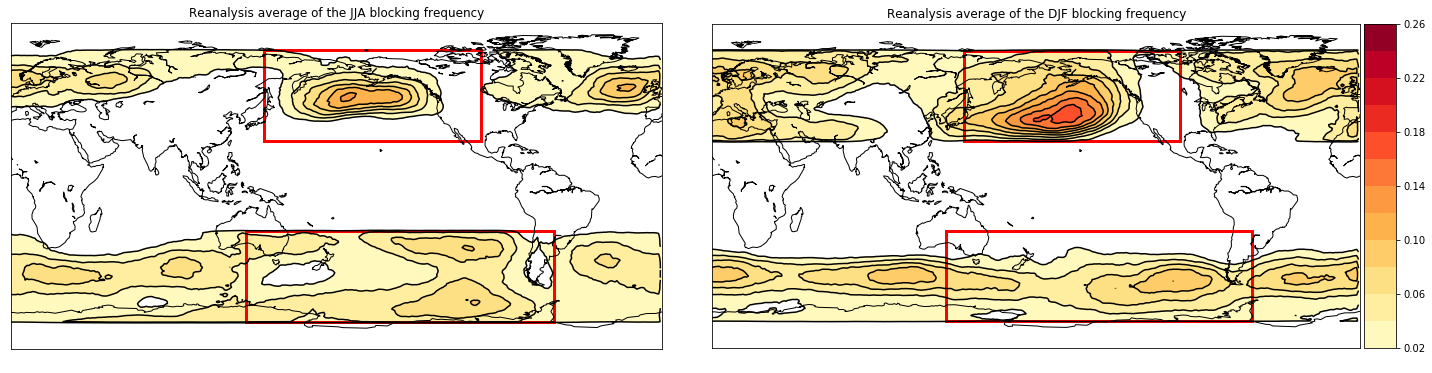

In [24]:
#Reanalysis
b_breaks=np.arange(0.02,0.28,0.02)
sstr1="Reanalysis average of the JJA blocking frequency"
sstr2="Reanalysis average of the DJF blocking frequency"
fig_r,ax_r=plot_freqs(avg_jja['reanBlockMean'],sstr1,avg_djf['reanBlockMean'],sstr2,b_breaks,"YlOrRd")
ax_r[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_r[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_r[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_r[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

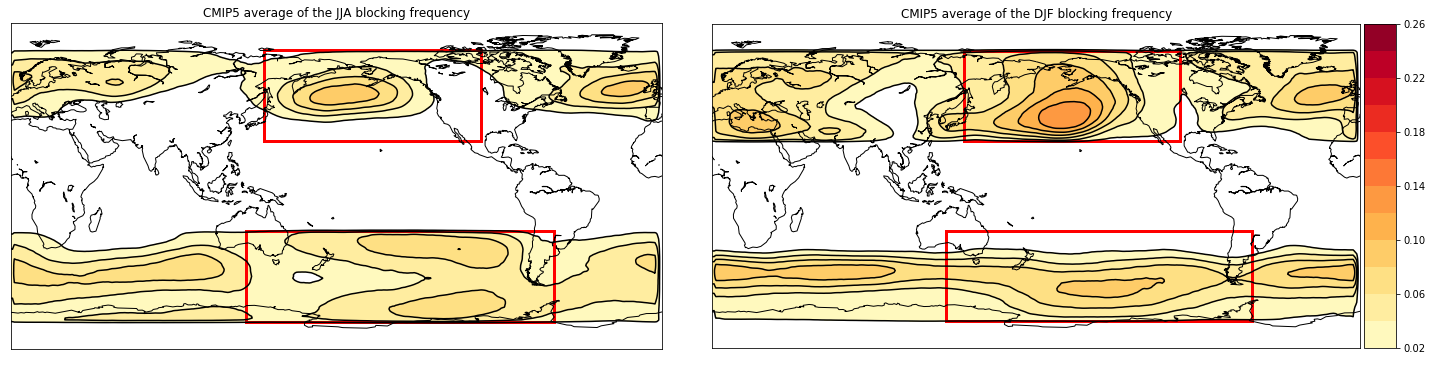

In [25]:
#Model
sstr1="CMIP5 average of the JJA blocking frequency"
sstr2="CMIP5 average of the DJF blocking frequency"
fig_m,ax_m=plot_freqs(avg_jja['modelBlockMean'],sstr1,avg_djf['modelBlockMean'],sstr2,b_breaks,"YlOrRd")
ax_m[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_m[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_m[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_m[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

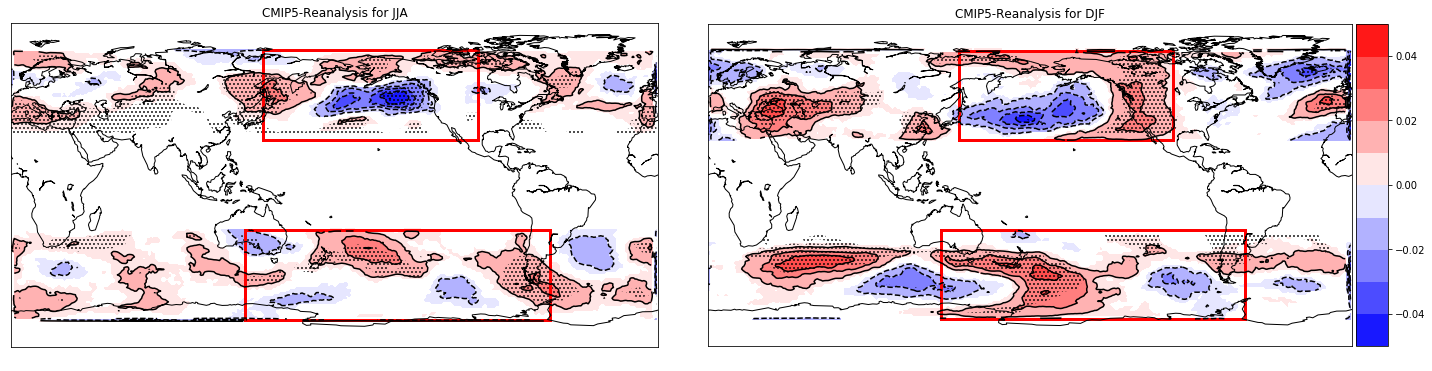

In [27]:
#Diffs
diff_breaks=np.arange(-0.05,0.06,0.01)
sstr1="CMIP5-Reanalysis for JJA"
sstr2="CMIP5-Reanalysis for DJF"
fig_d,ax_d=plot_diffs_w_sig(avg_jja['modelDiff'],sstr1,avg_djf['modelDiff'],sstr2,diff_breaks,"bwr",sig_jja,sig_djf)
ax_d[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_d[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_d[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_d[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

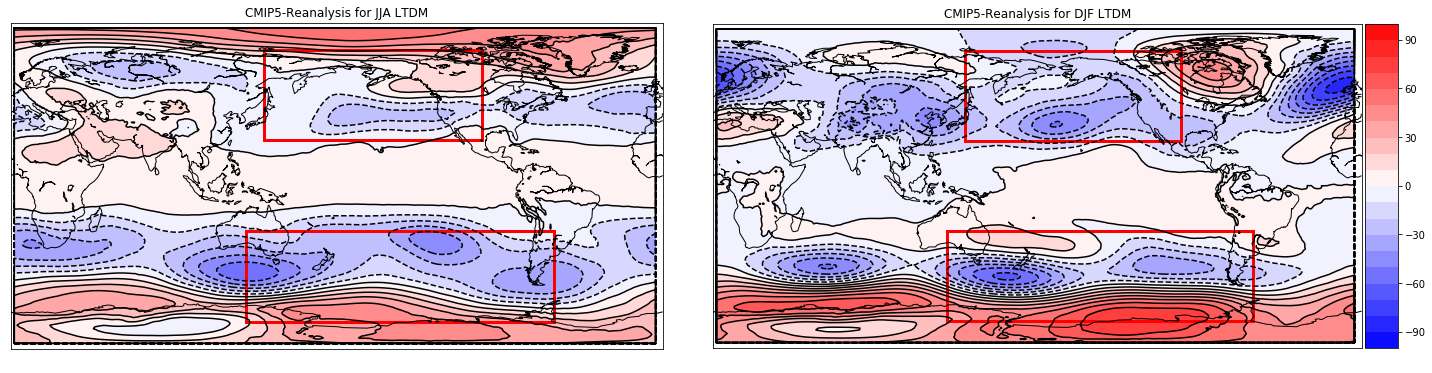

In [28]:
#Diffs LTDM
diff_breaks=np.arange(-100,110,10)
sstr1="CMIP5-Reanalysis for JJA LTDM"
sstr2="CMIP5-Reanalysis for DJF LTDM"
ltdm_diff_jja=az_jja['modelMean']-az_jja['reanMean']
ltdm_diff_djf=az_djf['modelMean']-az_djf['reanMean']
fig_d,ax_d=plot_freqs(ltdm_diff_jja,sstr1,ltdm_diff_djf,sstr2,diff_breaks,"bwr")
ax_d[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_d[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_d[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_d[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

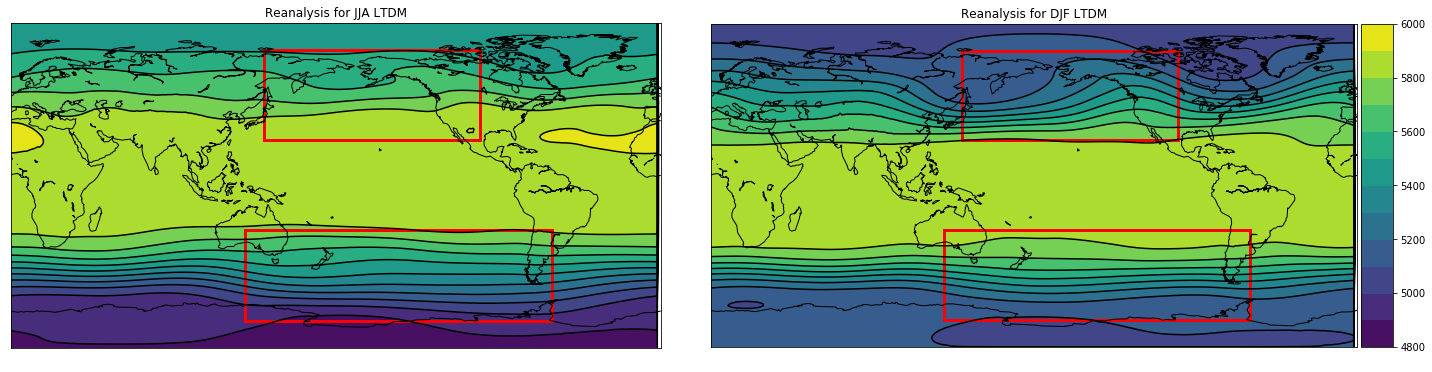

In [29]:
#REAN LTDM

sstr1="Reanalysis for JJA LTDM"
sstr2="Reanalysis for DJF LTDM"
ltdm_breaks=np.arange(4800,6100,100)
fig_l,ax_l=plot_freqs(az_jja['reanMean'],sstr1,az_djf['reanMean'],sstr2,ltdm_breaks,"viridis")
ax_l[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_l[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_l[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_l[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

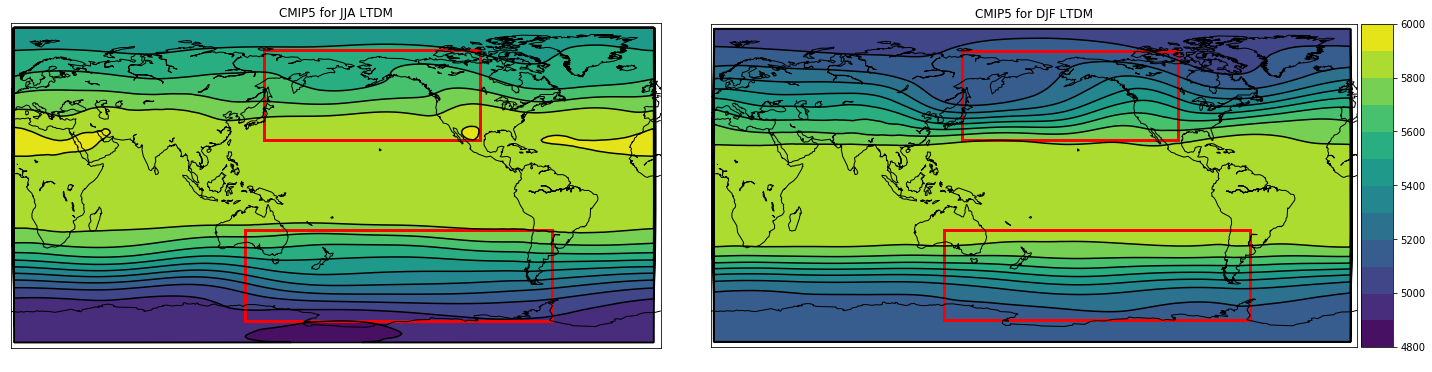

In [30]:
#MODEL LTDM

sstr1="CMIP5 for JJA LTDM"
sstr2="CMIP5 for DJF LTDM"
ltdm_breaks=np.arange(4800,6100,100)
fig_l,ax_l=plot_freqs(az_jja['modelMean'],sstr1,az_djf['modelMean'],sstr2,ltdm_breaks,"viridis")
ax_l[0].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_l[1].add_patch(patches.Rectangle((140,25),120,50,linewidth=3,edgecolor='r',fill=None))
ax_l[0].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))
ax_l[1].add_patch(patches.Rectangle((130,-75),170,50,linewidth=3,edgecolor='r',fill=None))

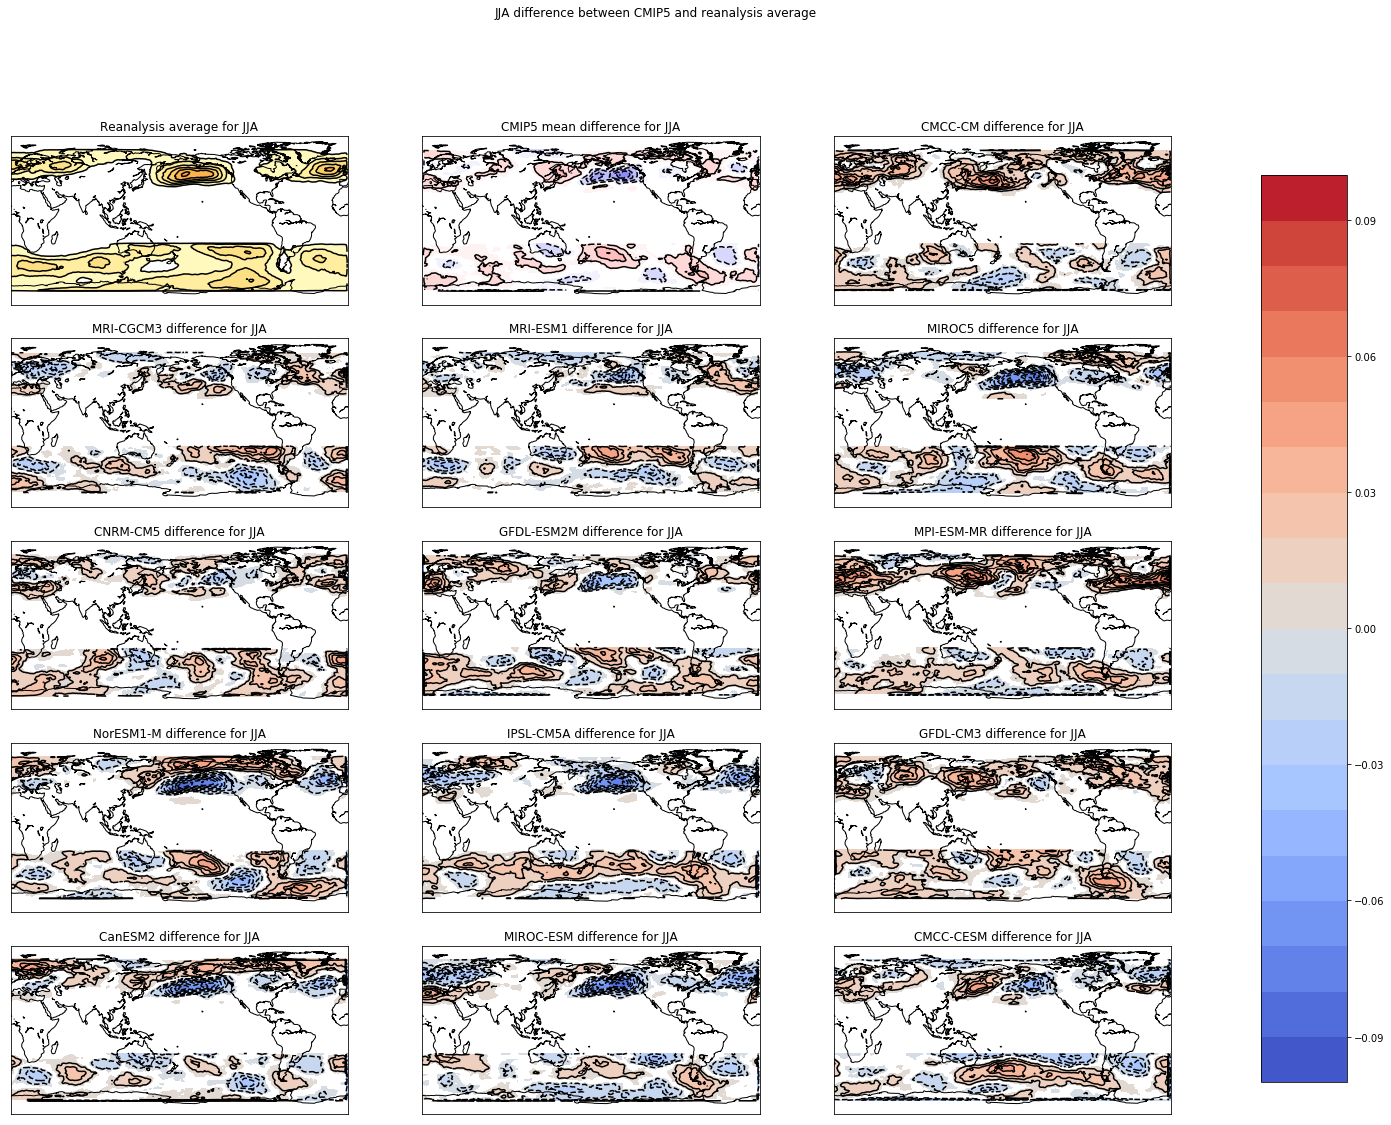

In [31]:
#Plot the differences between each model and the reanalysis mean
dc=0

#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("JJA difference between CMIP5 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_jja['reanBlockMean']
v2=avg_jja['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for JJA',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP5 mean difference for JJA',diff_breaks2,'bwr')

mc=0
for i in range(5):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_mod2[mv]
            v=avg_jja['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for JJA'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)
#plt.tight_layout()



In [ ]:
#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("DJF difference between CMIP5 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_djf['reanBlockMean']
v2=avg_djf['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for DJF',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP5 mean difference for DJF',diff_breaks2,'bwr')

mc=0
for i in range(5):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_mod2[mv]
            v=avg_djf['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for DJF'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)